In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import random,copy,math
import numpy as np
# from deap import benchmarks
import matplotlib.pyplot as plt
# import plotter
import time
pi = round(math.pi,6)
sin,cos,tan = math.sin,math.cos,math.tan



delta_t = 0.2
car_vel = 10
car_omega = 0
target_pos = np.array([10,10,0])

MAX_POPULATION_SIZE=20 #maximum number of plants in a colony(or population)
sigma_fin=0.01#final standard deviation
sigma_ini=35 #initial standard deviation
Smin=2#min seeds produced
Smax=10#max seeds produced
n_mi= 3 #modulation index
iter_max=1500 #Maximum number of iterations to be done
CHROMOSOME_SIZE=4 #F,

#Input Limits
v_x_min,v_x_max = -15,15
v_y_min,v_y_max = -15,15
v_z_min,v_z_max = -11,11
omega_x_min,omega_x_max = -(pi/5),pi/5
omega_y_min,omega_y_max = -(pi/5),pi/5
omega_z_min,omega_z_max = -(pi/5),pi/5

#class that generates chromosomes
class Chromosome:
    def __init__(self,state,tar_curr_state,mode =" "):
        self._genes=np.zeros((CHROMOSOME_SIZE+1),dtype=float)
        self._state = state #current state of the chaser
        self._tar_curr_state = tar_curr_state #current state of the target
        self.new_tar_state = 0

        #initializing the control parameters
        if mode=="initialise":  
            
            self._genes[0]= v_x_min+(v_x_max-v_x_min)*random.random()
            self._genes[1]= v_y_min+(v_y_max-v_y_min)*random.random()
            self._genes[2]= v_z_min+(v_z_max-v_z_min)*random.random()
            self._genes[3]= omega_x_min+(omega_x_max-omega_x_min)*random.random()
            self._genes[4]= omega_y_min+(omega_y_max-omega_y_min)*random.random()
            self._genes[5]= omega_z_min+(omega_z_max-omega_z_min)*random.random()

        self._cost = self.get_cost() #calculating cost
        self._genes[-1] = self._cost #adding cost to the genes

        # self._genes=np.around(self._genes,6)
        #print("TARGET_CHROMOSOME",TARGET_CHROMOSOME,'\n')

    def get_genes(self):
        return self._genes

    def get_cost(self):
        # v_x,v_y,v_z,omega_x,omega_y,omega_z = self._genes[:-1]
        vel = self._genes[:3]
        omega = self._genes[3:-1]

        pos = self._state[0]
        angle = self._state[1]
        phi,theta,psi = angle

        
        
        
        
        pos = pos + np.matmul(rotmat_velocity,vel)*delta_t
        angle = angle + omega*delta_t
     

        curr_pos = np.array([pos,angle])

        #getting target position
        self.new_target_state = self.cal_target_state() #updating new target state
        self._state = curr_pos #updating new chaser state
        cost = np.sum((self.new_target_state[:3]-curr_pos[0][:3])**2) #+ abs(curr_pos[0][2]-50))/51 #- curr_pos[0][2]*1000 #calculating cost

        return cost

    def get_state(self):
        return self._state

    def cal_target_state(self):
        theta = self._tar_curr_state[-1] + (car_omega*delta_t)
        x = self._tar_curr_state[0] + car_vel * math.cos(theta) * delta_t
        y = self._tar_curr_state[1] + car_vel * math.sin(theta) * delta_t
        return np.array([x,y,0,theta])

    def get_target_state(self):
      return self.new_target_state
    
    def __str__(self):
        return self._genes.__str__()

#class that create one set of generations
class Population:
    def __init__(self,size,curr_state,tar_curr_state,mode=" "):
        self._chromosomes=[]
        i=0
        while i<size:
            self.add_chromosomes(Chromosome(curr_state,tar_curr_state,mode))
            i+=1
    def add_chromosomes(self,chromosome):
        self._chromosomes.append(chromosome)
    def get_chromosomes(self):
        return self._chromosomes

#class that helps in evolving and mutating the genes of the chromosomes
class GeneticAlgorithm:

    @staticmethod
    def reproduce(pop,iter,curr_state,tar_curr_state):
        new_pop=copy.deepcopy(pop)
        worst_cost=pop.get_chromosomes()[MAX_POPULATION_SIZE-1].get_genes()[CHROMOSOME_SIZE]
        best_cost=pop.get_chromosomes()[0].get_genes()[CHROMOSOME_SIZE]
        sigma_iter=GeneticAlgorithm.std_deviation(iter,iter_max)
        if(best_cost!=worst_cost):
            #print("before sorting")
            for i in range(MAX_POPULATION_SIZE):
                ratio=(pop.get_chromosomes()[i].get_genes()[CHROMOSOME_SIZE]-worst_cost)/(best_cost-worst_cost)
                S=Smin+(Smax-Smin)*ratio #number of seeds chromosome can produce on the basis of rank
                for j in range(int(S)):
                    seed=Chromosome(curr_state,tar_curr_state)
                    for k in range(CHROMOSOME_SIZE):
                        seed._genes[k]=np.random.normal(pop._chromosomes[i].get_genes()[k],sigma_iter)
                    # seed._genes[-1]=seed.get_cost()
                    # seed._genes=np.around(seed._genes,3)
                    new_pop.add_chromosomes(seed)
            GeneticAlgorithm.sort(new_pop)
            pop._chromosomes=new_pop._chromosomes[:MAX_POPULATION_SIZE]
            # for i in range(MAX_POPULATION_SIZE):
            #     pop._chromosomes[i]=new_pop._chromosomes[i]
        else:
            # print("best and worst cost equal")
            return pop, False
        # print("REPRODUCED")
        return pop, True
    @staticmethod
    def std_deviation(iter,iter_max):
        sigma_iter=(((iter_max-iter)**n_mi)/iter_max**n_mi)*(sigma_ini-sigma_fin)+sigma_fin
        # print ("sigma",sigma_iter,'\n')
        return sigma_iter
    @staticmethod
    def sort(pop):
        pop_chroms_2d_array=np.array([pop.get_chromosomes()[i].get_genes() for i in range(len(pop._chromosomes))])
        sindices=np.argsort(pop_chroms_2d_array[:,CHROMOSOME_SIZE],axis=0)
        # sindices = np.flip(sindices)  #To maximize
        sorted_chroms=pop.get_chromosomes()
        for i in range(0,len(pop._chromosomes)):
            sorted_chroms[i]._genes=pop_chroms_2d_array[sindices[i]]
            sorted_chroms[i]._state = pop._chromosomes[sindices[i]]._state
        #for i in range(0,len(pop._chromosomes)):
        pop._chromosomes=sorted_chroms
        # print("SORTED")
#------------------------------------------------------------------------------------------------------------------------------------#-
def _print_population(pop,gen_number,fitness):
    print("\n---------------------------------------------------------")
    print("Generation#",gen_number,"|Fittest chromosome fitness:",pop.get_chromosomes()[0].get_genes()[CHROMOSOME_SIZE])
    #print("Target Chromosome:",TARGET_CHROMOSOME)
    print("-----------------------------------------------------------")
    fitness.append(pop.get_chromosomes()[0].get_genes()[CHROMOSOME_SIZE])
    i=0
    for x in pop.get_chromosomes():
        print("Chromosome #",i+1,":",x.get_genes(),"|State: ",x.get_state(),"|Fitness:",x.get_genes()[CHROMOSOME_SIZE])
        k=x.get_genes()[CHROMOSOME_SIZE]
        # handle.write(str(gen_number)+' '+str(x.get_genes()[-1])+'\n')
        #fitness=np.append(fitness,[x.get_genes()[CHROMOSOME_SIZE]],1)
        #dplot.update(gen_number,pop.get_chromosomes()[0].get_genes()[CHROMOSOME_SIZE])
        i+=1


def optimizer(curr_state,tar_curr_state):
  # print("INITIATING PROGRAMME")
  population=Population(MAX_POPULATION_SIZE,curr_state,tar_curr_state,"initialise")#initialising population
  GeneticAlgorithm.sort(population)
  fitness = []
  iter=1
  
  while iter<iter_max:

      population,check=GeneticAlgorithm.reproduce(population,iter,curr_state,tar_curr_state)

      if(check==False):
          #iter+=1
          break;
      # minfit.append(population.get_chromosomes()[-1].get_genes()[-1])
      # _print_population(population,iter,fitness)
      iter+=1
  # print(population.get_chromosomes()[0].get_state())
  new_chaser_state,new_target_state = population.get_chromosomes()[0].get_state(),population.get_chromosomes()[0].get_target_state()
  return(new_chaser_state,new_target_state)



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline


initial_state = np.array([[0,0,50],[0,0,0]])
target_initial_state = np.array([10,10,0,pi/2])

curr_state,target_curr_state = optimizer(initial_state,target_initial_state)

num_steps = 100
j=0
chaser_states = [initial_state]
target_states = [target_initial_state]
while j <= num_steps:
  
  curr_state,target_curr_state = optimizer(curr_state,target_curr_state)
  print("\nstep: ",j,"chaser state: ", curr_state, "target state: ",target_curr_state)
  chaser_states.append(curr_state.tolist())
  target_states.append(target_curr_state.tolist())

  #plotting
  chaser_states_l = np.array(chaser_states)
  target_states_l = np.array(target_states)

  # plt.close()
  fig = plt.figure()
  ax = fig.gca(projection="3d")
  ax.plot(target_states_l.T[0], target_states_l.T[1], target_states_l.T[2],label = "Target");
  ax.plot(chaser_states_l[:,0].T[0], chaser_states_l[:,0].T[1], chaser_states_l[:,0].T[2],label = "Chaser");
  # ax.plot(curr_state[0][0],curr_state[0][1],curr_state[0][2])
  # ax.plot(target_curr_state[0],target_curr_state[1],target_curr_state[2])
  # plt.legend()
  ax.legend()
  plt.show()

  j+=1

chaser_states = np.array(chaser_states)
target_states = np.array(target_states)
# print(states)







IndexError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


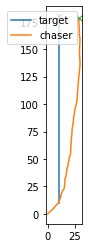

In [ ]:
plt.plot(target_states_l.T[0],target_states_l.T[1],label = "target")
plt.plot(chaser_states_l[:,0].T[0],chaser_states_l[:,0].T[1],label = "chaser")
plt.plot(chaser_states_l[:,0].T[0][-1],chaser_states_l[:,0].T[1][-1],"x")
plt.plot(target_states_l.T[0][-1],target_states_l.T[1][-1],"x")
plt.axes().set_aspect("equal")
plt.legend()
plt.show()
# plt.savefig('/content/drive/My Drive/MTE_Project/chaser4.jpg')

In [ ]:
vel = np.array([10,12,10])
omega = np.array([pi/10,pi/10,pi/10])

pos = np.array([0,0,0])
angle = np.array([0,0,0])
phi,theta,psi = angle

rotmat_omega = np.array([[1,sin(phi)*tan(theta),cos(phi)*tan(theta)],\
                          [0,cos(phi),-sin(phi)],\
                          [0,sin(phi)/cos(theta),cos(phi)/cos(theta)]])

rotmat_velocity = np.array([[cos(theta)*cos(psi),sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi),cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],\
                            [cos(theta)*sin(psi),sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi),cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],\
                            [sin(theta),-sin(phi)*cos(theta),-cos(phi)*cos(theta)]])

pos = pos + np.matmul(rotmat_velocity,vel)*delta_t
# print("pos",pos) #testcode
# print("mat",np.matmul(rotmat_velocity,vel)*delta_t) #testcode
# print("rotmat",rotmat_velocity)
angle = angle + np.matmul(rotmat_omega,omega)*delta_t
print("angle",angle)
print("rotmat_om",rotmat_omega)

curr_pos = np.array([pos,angle])
print("curr_pos",curr_pos)

# #getting target position
# self.new_target_state = self.cal_target_state() #updating new target state
# self._state = curr_pos #updating new chaser state
# cost = np.sqrt(np.sum((self.new_target_state[:-1]-curr_pos[0])**2)) #calculating cost

angle [0.06283186 0.06283186 0.06283186]
rotmat_om [[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]
curr_pos [[ 2.          2.4        -2.        ]
 [ 0.06283186  0.06283186  0.06283186]]
